In [3]:
from data import generate_dataset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split

n = 1000

x, y, y_noisy1 = generate_dataset(n=n, noise_std=0.5, random_state=1)
_, _, y_noisy2 = generate_dataset(n=n, noise_std=1.0, random_state=1)
_, _, y_noisy3 = generate_dataset(n=n, noise_std=2.0, random_state=1)
_, _, y = generate_dataset(n=n, noise_std=0, random_state=1)

In [4]:

def design_matrix(x, degree):
    return np.vstack([x**i for i in range(degree+1)]).T

def mse(y, y_hat):
    return np.mean((y - y_hat)**2)

def r2(y, y_hat):
    return 1 - np.sum((y - y_hat)**2) / np.sum((y - np.mean(y))**2)

x_train, x_test = train_test_split(x, test_size=0.2, random_state=42)


_, _, y1_train, y1_test = train_test_split(x, y_noisy1, test_size=0.2, random_state=42)
_, _, y2_train, y2_test = train_test_split(x, y_noisy2, test_size=0.2, random_state=42)
_, _, y3_train, y3_test = train_test_split(x, y_noisy3, test_size=0.2, random_state=42)
_, _, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 1)).flatten()
x_test_scaled = scaler.transform(x_test.reshape(-1, 1)).flatten()

In [5]:
def _iter_minibatches(n, batch_size, rng):
    bs = min(batch_size, n)
    idx = rng.choice(n, size=bs, replace=False)
    return idx

def sgd_ols(X_train, y_train, X_test, y_test, eta=0.1, num_steps=1000, batch_size=32, seed=0):
    n, d = X_train.shape
    theta = np.zeros(d)
    rng = np.random.default_rng(seed)
    mse_train, mse_test = [], []
    for _ in range(num_steps):
        idx = _iter_minibatches(n, batch_size, rng)
        Xb, yb = X_train[idx], y_train[idx]
        grad = (2.0/len(idx)) * (Xb.T @ (Xb @ theta - yb))
        theta -= eta * grad
        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test,  X_test  @ theta))
    return theta, mse_train, mse_test

def sgd_momentum(X_train, y_train, X_test, y_test, eta=0.01, num_steps=1000, gamma=0.9, batch_size=32, seed=0):
    n, d = X_train.shape
    theta = np.zeros(d); v = np.zeros(d)
    rng = np.random.default_rng(seed)
    mse_train, mse_test = [], []
    for _ in range(num_steps):
        idx = _iter_minibatches(n, batch_size, rng)
        Xb, yb = X_train[idx], y_train[idx]
        grad = (2.0/len(idx)) * (Xb.T @ (Xb @ theta - yb))
        v = gamma * v + eta * grad
        theta -= v
        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test,  X_test  @ theta))
    return theta, mse_train, mse_test

def sgd_adagrad(X_train, y_train, X_test, y_test, eta=0.01, num_steps=1000, eps=1e-8, batch_size=32, seed=0):
    n, d = X_train.shape
    theta = np.zeros(d); G = np.zeros(d)
    rng = np.random.default_rng(seed)
    mse_train, mse_test = [], []
    for _ in range(num_steps):
        idx = _iter_minibatches(n, batch_size, rng)
        Xb, yb = X_train[idx], y_train[idx]
        grad = (2.0/len(idx)) * (Xb.T @ (Xb @ theta - yb))
        G += grad**2
        theta -= (eta / (np.sqrt(G) + eps)) * grad
        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test,  X_test  @ theta))
    return theta, mse_train, mse_test

def sgd_rmsprop(X_train, y_train, X_test, y_test, eta=0.01, num_steps=1000, beta=0.9, eps=1e-8, batch_size=32, seed=0):
    n, d = X_train.shape
    theta = np.zeros(d); Eg = np.zeros(d)
    rng = np.random.default_rng(seed)
    mse_train, mse_test = [], []
    for _ in range(num_steps):
        idx = _iter_minibatches(n, batch_size, rng)
        Xb, yb = X_train[idx], y_train[idx]
        grad = (2.0/len(idx)) * (Xb.T @ (Xb @ theta - yb))
        Eg = beta * Eg + (1-beta) * grad**2
        theta -= (eta / (np.sqrt(Eg) + eps)) * grad
        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test,  X_test  @ theta))
    return theta, mse_train, mse_test

def sgd_adam(X_train, y_train, X_test, y_test, eta=0.01, num_steps=1000, beta1=0.9, beta2=0.999, eps=1e-8, batch_size=32, seed=0):
    n, d = X_train.shape
    theta = np.zeros(d); m = np.zeros(d); v = np.zeros(d)
    rng = np.random.default_rng(seed)
    mse_train, mse_test = [], []
    for t in range(1, num_steps+1):
        idx = _iter_minibatches(n, batch_size, rng)
        Xb, yb = X_train[idx], y_train[idx]
        grad = (2.0/len(idx)) * (Xb.T @ (Xb @ theta - yb))
        m = beta1*m + (1-beta1)*grad
        v = beta2*v + (1-beta2)*(grad**2)
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        theta -= eta * m_hat / (np.sqrt(v_hat) + eps)
        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test,  X_test  @ theta))
    return theta, mse_train, mse_test




degrees = range(1, 16)

def run_optimizer_experiments_sgd(
    x_train, y_train, x_test, y_test,
    degrees,
    etas=None,
    batch_sizes=None,
    num_steps=1000,
    seed=0
):
    if etas is None:
        etas = [1e-6, 1e-4, 1e-3, 1e-2, 0.05]
    if batch_sizes is None:
        batch_sizes = [16, 32, 64, 128, 256]  

    results = []
    for degree in degrees:
        X_train = design_matrix(x_train, degree)
        X_test  = design_matrix(x_test, degree)

        for bs in batch_sizes:
            for eta in etas:
                methods = {
                    "SGD":      (lambda eta=eta, bs=bs: sgd_ols(X_train, y_train, X_test, y_test, eta=eta, num_steps=num_steps, batch_size=bs, seed=seed)),
                    "Momentum": (lambda eta=eta, bs=bs: sgd_momentum(X_train, y_train, X_test, y_test, eta=eta, num_steps=num_steps, batch_size=bs, seed=seed)),
                    "AdaGrad":  (lambda eta=eta, bs=bs: sgd_adagrad(X_train, y_train, X_test, y_test, eta=eta, num_steps=num_steps, batch_size=bs, seed=seed)),
                    "RMSProp":  (lambda eta=eta, bs=bs: sgd_rmsprop(X_train, y_train, X_test, y_test, eta=eta, num_steps=num_steps, batch_size=bs, seed=seed)),
                    "Adam":     (lambda eta=eta, bs=bs: sgd_adam(X_train, y_train, X_test, y_test, eta=eta, num_steps=num_steps, batch_size=bs, seed=seed)),
                }

                for name, f in methods.items():
                    _, tr_hist, te_hist = f()
                    for t, (tr, te) in enumerate(zip(tr_hist, te_hist), start=1):
                        results.append([name, degree, eta, bs, t, tr, te])

    df = pd.DataFrame(results, columns=["Method","Degree","Eta","Batch","Iteration","Train MSE","Test MSE"])
    return df


In [6]:
df_sgd = run_optimizer_experiments_sgd(
    x_train_scaled, y1_train, x_test_scaled, y1_test,
    degrees=range(1, 16),
    etas=[1e-6, 1e-4, 1e-3, 1e-2, 0.05],
    batch_sizes=[16, 32, 64, 128, 256],
    num_steps=1000,
    seed=1
)


c:\hermanis\miniconda3\envs\geo\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_17832\2141137981.py:5: RuntimeWarning: overflow encountered in square
  return np.mean((y - y_hat)**2)
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_17832\1989278346.py:14: RuntimeWarning: overflow encountered in matmul
  grad = (2.0/len(idx)) * (Xb.T @ (Xb @ theta - yb))
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_17832\1989278346.py:16: RuntimeWarning: invalid value encountered in matmul
  mse_train.append(mse(y_train, X_train @ theta))
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_17832\1989278346.py:17: RuntimeWarning: invalid value encountered in matmul
  mse_test.append(mse(y_test,  X_test  @ theta))
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_17832\1989278346.py:14: RuntimeWarning: 

In [13]:
final_sgd = (df_sgd.sort_values("Iteration")
                    .groupby(["Method","Degree","Eta","Batch"], as_index=False)
                    .tail(1))
final_sgd = final_sgd[np.isfinite(final_sgd["Test MSE"])]
final_sgd = final_sgd[final_sgd["Test MSE"] < 1e3]


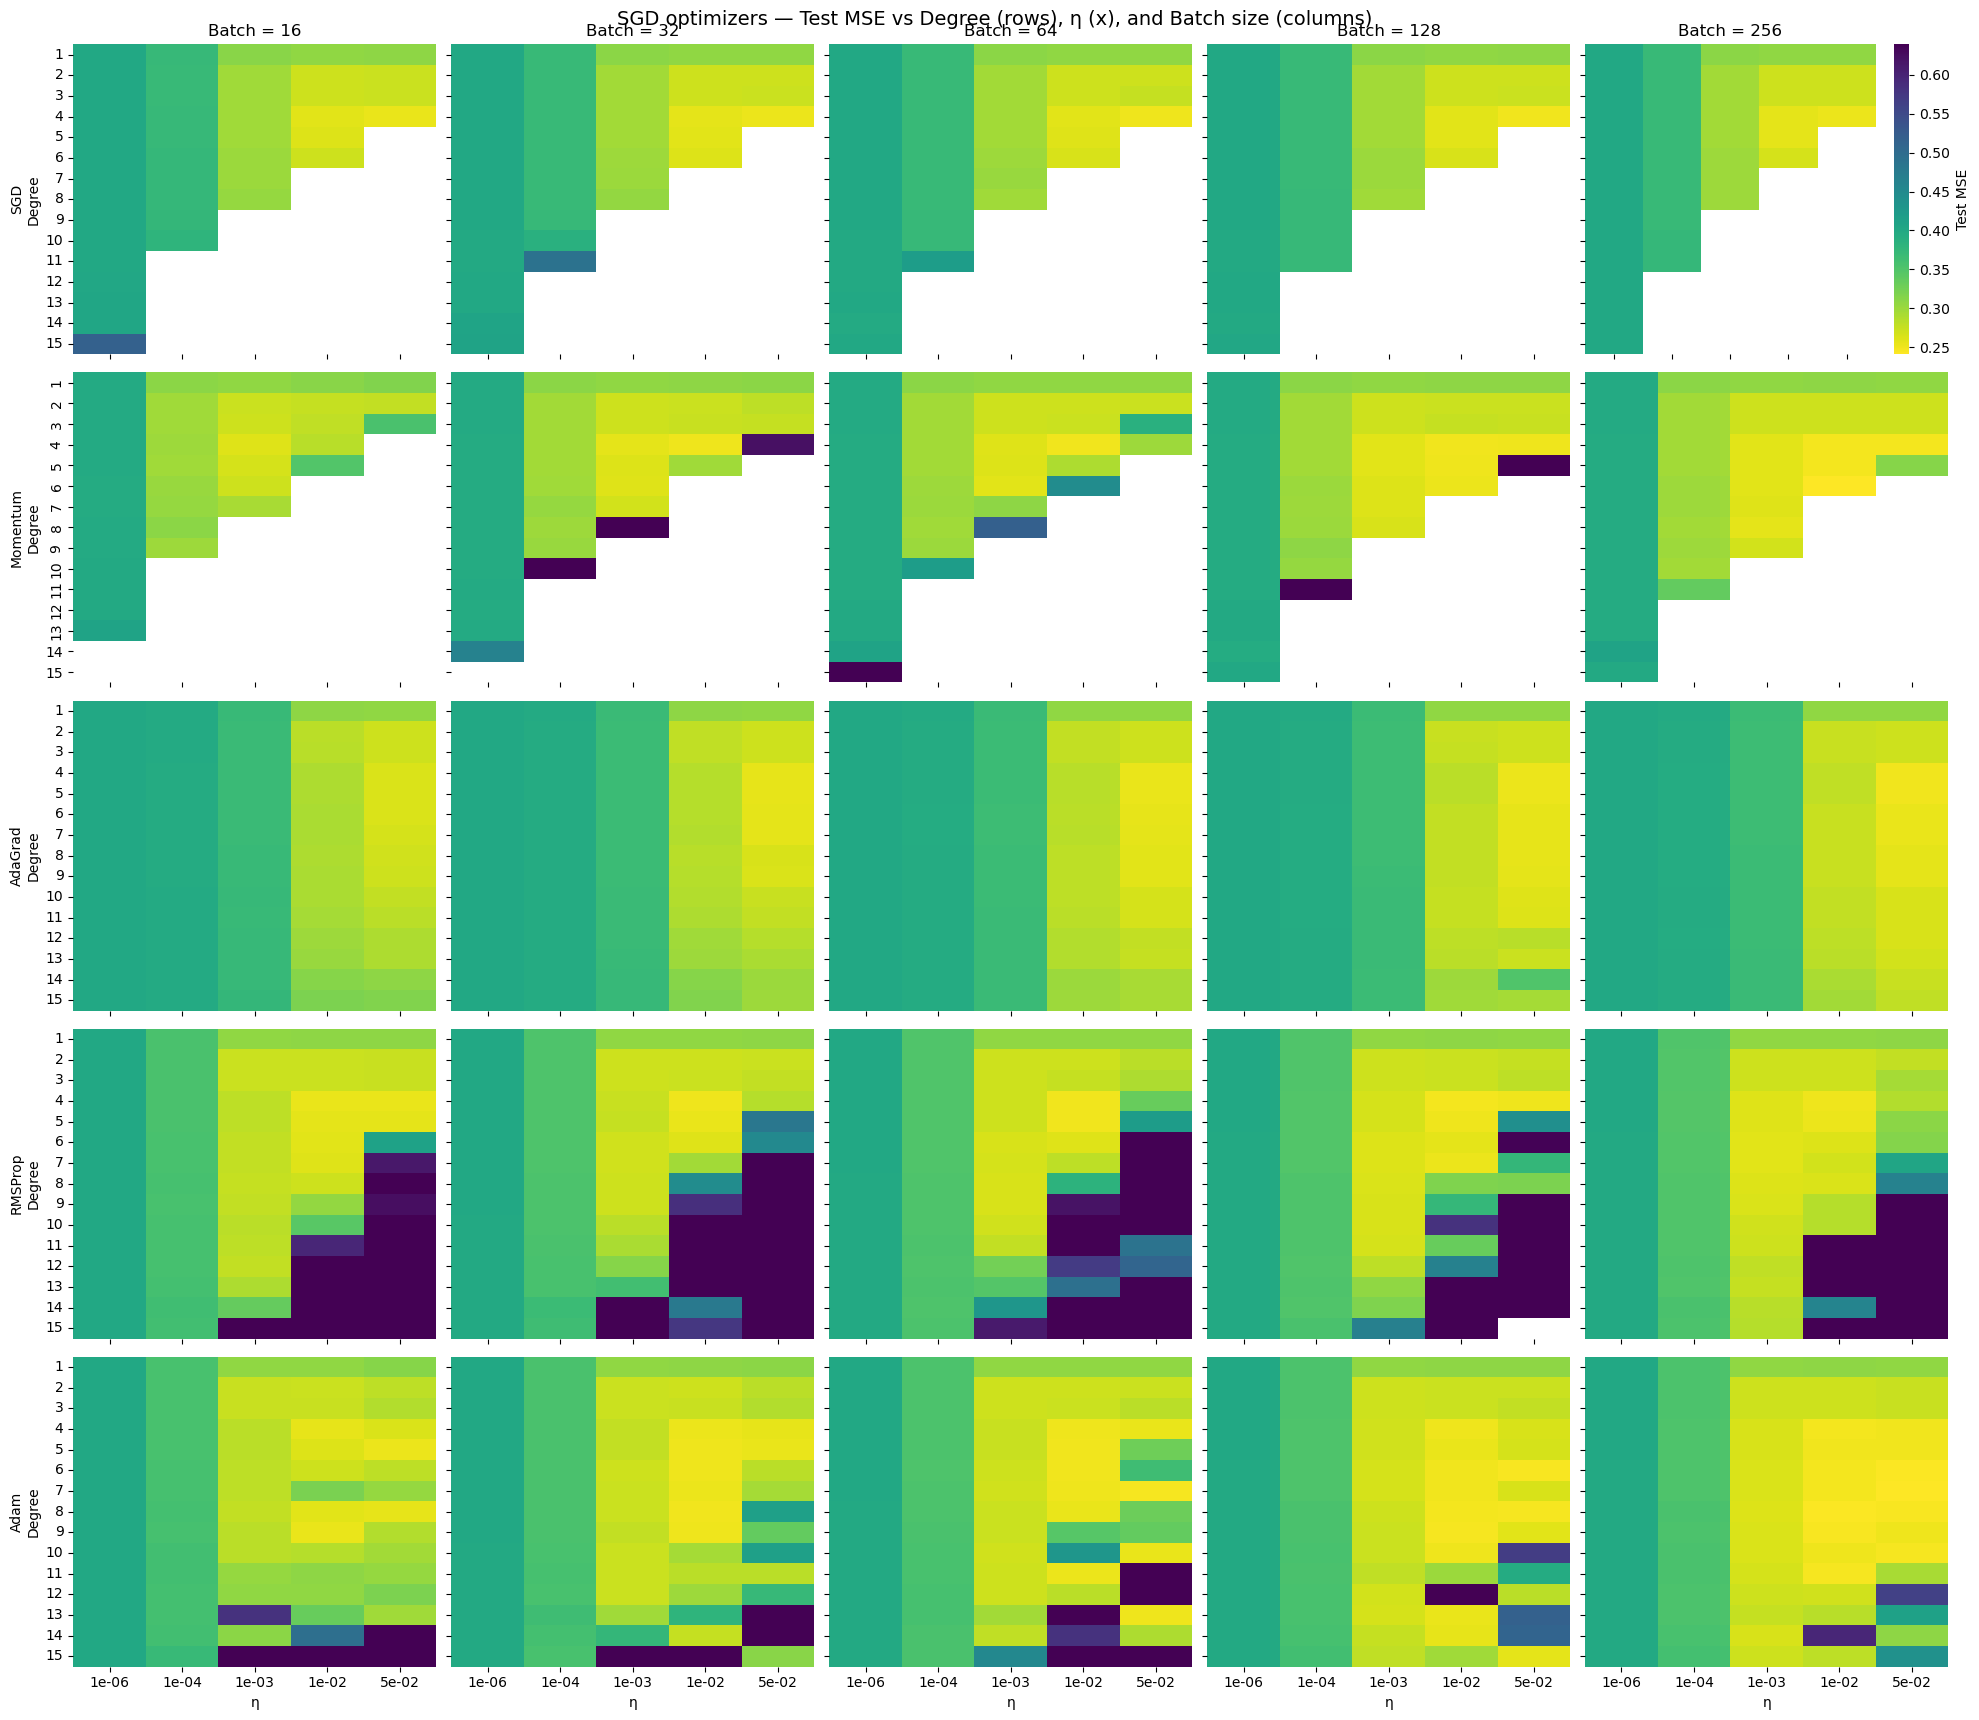

In [15]:
import seaborn as sns

methods = ["SGD","Momentum","AdaGrad","RMSProp","Adam"]
batches = sorted(final_sgd["Batch"].unique())

fig, axes = plt.subplots(len(methods), len(batches),
                         figsize=(4*len(batches), 3.5*len(methods)),
                         sharex=True, sharey=True)

vmin = final_sgd["Test MSE"].min()
vmax = final_sgd["Test MSE"].quantile(0.95)

for i, method in enumerate(methods):
    for j, bs in enumerate(batches):
        ax = axes[i, j]
        sub = final_sgd[(final_sgd["Method"]==method) & (final_sgd["Batch"]==bs)]
        pivot = sub.pivot_table(index="Degree", columns="Eta", values="Test MSE", aggfunc="mean")
        if pivot.empty:
            ax.axis("off"); continue

        sns.heatmap(pivot, cmap="viridis_r", vmin=vmin, vmax=vmax,
                    annot=False, ax=ax,
                    cbar=(i==0 and j==len(batches)-1),
                    cbar_kws={'label':'Test MSE'})
        if i == 0: ax.set_title(f"Batch = {bs}")
        if j == 0: ax.set_ylabel(f"{method}\nDegree")
        else: ax.set_ylabel("")
        if i == len(methods)-1:
            ax.set_xlabel("η")
            ax.set_xticklabels([f"{e:.0e}" for e in pivot.columns], rotation=0)
        else:
            ax.set_xlabel("")

plt.suptitle("SGD optimizers — Test MSE vs Degree (rows), η (x), and Batch size (columns)", fontsize=14)
plt.tight_layout()
plt.show()

In [29]:
best_per_opt = final_sgd.loc[final_sgd.groupby("Method")["Test MSE"].idxmin()]
print(best_per_opt[["Method","Degree","Eta","Batch","Test MSE"]])

best_per_batch = final_sgd.loc[
    final_sgd.groupby(["Batch"])["Test MSE"].idxmin()
]
print(best_per_batch[["Method","Degree","Eta","Batch","Test MSE"]])

          Method  Degree   Eta  Batch  Test MSE
497999   AdaGrad       4  0.05    256  0.249719
874999      Adam       7  0.05    256  0.240865
741999  Momentum       6  0.01    256  0.240803
468999   RMSProp       4  0.01    128  0.248264
470999       SGD       4  0.05    128  0.249491
          Method  Degree   Eta  Batch  Test MSE
524999      Adam       5  0.05     16  0.252313
919999      Adam       8  0.01     32  0.249882
824999      Adam       7  0.05     64  0.246461
724999      Adam       6  0.05    128  0.243957
741999  Momentum       6  0.01    256  0.240803


In [17]:
def sgd_ridge(X_train, y_train, X_test, y_test, lam=0.1, eta=0.1, num_iters=100, batch_size=32):
    n, d = X_train.shape
    theta = np.zeros(d)
    mse_train, mse_test = [], []
    for _ in range(num_iters):
        idx = np.random.choice(n, batch_size, replace=False)
        X_batch, y_batch = X_train[idx], y_train[idx]
        grad = (2.0/batch_size) * (X_batch.T @ (X_batch @ theta - y_batch)) + 2*lam*theta
        theta -= eta * grad
        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test, X_test @ theta))
    return theta, mse_train, mse_test


def sgd_momentum_ridge(X_train, y_train, X_test, y_test, lam=0.1, eta=0.01, num_iters=1000, gamma=0.9, batch_size=32):
    n, d = X_train.shape
    theta = np.zeros(d)
    v = np.zeros(d)
    mse_train, mse_test = [], []
    for _ in range(num_iters):
        idx = np.random.choice(n, batch_size, replace=False)
        X_batch, y_batch = X_train[idx], y_train[idx]
        grad = (2.0/batch_size) * (X_batch.T @ (X_batch @ theta - y_batch)) + 2*lam*theta
        v = gamma * v + eta * grad
        theta -= v
        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test, X_test @ theta))
    return theta, mse_train, mse_test


def sgd_adagrad_ridge(X_train, y_train, X_test, y_test, lam=0.1, eta=0.01, num_iters=1000, eps=1e-8, batch_size=32):
    n, d = X_train.shape
    theta = np.zeros(d)
    G = np.zeros(d)
    mse_train, mse_test = [], []
    for _ in range(num_iters):
        idx = np.random.choice(n, batch_size, replace=False)
        X_batch, y_batch = X_train[idx], y_train[idx]
        grad = (2.0/batch_size) * (X_batch.T @ (X_batch @ theta - y_batch)) + 2*lam*theta
        G += grad**2
        theta -= (eta / (np.sqrt(G) + eps)) * grad
        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test, X_test @ theta))
    return theta, mse_train, mse_test


def sgd_rmsprop_ridge(X_train, y_train, X_test, y_test, lam=0.1, eta=0.01, num_iters=1000, beta=0.9, eps=1e-8, batch_size=32):
    n, d = X_train.shape
    theta = np.zeros(d)
    Eg = np.zeros(d)
    mse_train, mse_test = [], []
    for _ in range(num_iters):
        idx = np.random.choice(n, batch_size, replace=False)
        X_batch, y_batch = X_train[idx], y_train[idx]
        grad = (2.0/batch_size) * (X_batch.T @ (X_batch @ theta - y_batch)) + 2*lam*theta
        Eg = beta * Eg + (1-beta) * grad**2
        theta -= (eta / (np.sqrt(Eg) + eps)) * grad
        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test, X_test @ theta))
    return theta, mse_train, mse_test


def sgd_adam_ridge(X_train, y_train, X_test, y_test, lam=0.1, eta=0.01, num_iters=1000, beta1=0.9, beta2=0.999, eps=1e-8, batch_size=32):
    n, d = X_train.shape
    theta = np.zeros(d)
    m = np.zeros(d)
    v = np.zeros(d)
    mse_train, mse_test = [], []
    for t in range(1, num_iters+1): 
        idx = np.random.choice(n, batch_size, replace=False)
        X_batch, y_batch = X_train[idx], y_train[idx]
        grad = (2.0/batch_size) * (X_batch.T @ (X_batch @ theta - y_batch)) + 2*lam*theta
        m = beta1*m + (1-beta1)*grad
        v = beta2*v + (1-beta2)*(grad**2)
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        theta -= eta * m_hat / (np.sqrt(v_hat) + eps)
        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test, X_test @ theta))
    return theta, mse_train, mse_test

def run_optimizer_experiments_sgd_ridge(
    x_train, y_train, x_test, y_test,
    degrees,
    lams=None,
    etas=None,
    batch_sizes=None,
    num_steps=1000,
    seed=1,
):
    if lams is None:
        lams = [1e-6, 1e-3, 1, 3, 10]
    if etas is None:
        etas = [1e-6, 1e-4, 1e-3, 1e-2, 0.05]
    if batch_sizes is None:
        batch_sizes = [16, 32, 64, 128, 256]

    results = []
    n_rng = np.random.default_rng(seed)  

    for degree in degrees:
        X_train = design_matrix(x_train, degree)
        X_test  = design_matrix(x_test, degree)

        for lam in lams:
            for bs in batch_sizes:
                for eta in etas:
              
                    methods = {
                        "SGD":      (lambda lam=lam, eta=eta, bs=bs:
                            sgd_ridge(X_train, y_train, X_test, y_test,
                                      lam=lam, eta=eta, num_iters=num_steps, batch_size=bs)),
                        "Momentum": (lambda lam=lam, eta=eta, bs=bs:
                            sgd_momentum_ridge(X_train, y_train, X_test, y_test,
                                               lam=lam, eta=eta, num_iters=num_steps, batch_size=bs)),
                        "AdaGrad":  (lambda lam=lam, eta=eta, bs=bs:
                            sgd_adagrad_ridge(X_train, y_train, X_test, y_test,
                                              lam=lam, eta=eta, num_iters=num_steps, batch_size=bs)),
                        "RMSProp":  (lambda lam=lam, eta=eta, bs=bs:
                            sgd_rmsprop_ridge(X_train, y_train, X_test, y_test,
                                              lam=lam, eta=eta, num_iters=num_steps, batch_size=bs)),
                        "Adam":     (lambda lam=lam, eta=eta, bs=bs:
                            sgd_adam_ridge(X_train, y_train, X_test, y_test,
                                            lam=lam, eta=eta, num_iters=num_steps, batch_size=bs)),
                    }

                    for name, f in methods.items():
                        _, tr_hist, te_hist = f()
                        for t, (tr, te) in enumerate(zip(tr_hist, te_hist), start=1):
                            results.append([name, degree, lam, eta, bs, t, tr, te])

    df = pd.DataFrame(results, columns=[
        "Method", "Degree", "Lambda", "Eta", "Batch", "Iteration", "Train MSE", "Test MSE"
    ])
    return df


In [18]:
df_sgd_ridge = run_optimizer_experiments_sgd_ridge(
    x_train_scaled, y1_train, x_test_scaled, y1_test,
    degrees=range(1,16),
    lams=[1e-6,1e-3,1,3,10],
    etas=[1e-6,1e-4,1e-3,1e-2,0.05],
    batch_sizes=[16,32,64,128,256],
    num_steps=1000,
    seed=1
)


c:\hermanis\miniconda3\envs\geo\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_17832\2141137981.py:5: RuntimeWarning: overflow encountered in square
  return np.mean((y - y_hat)**2)
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_17832\1481100702.py:8: RuntimeWarning: overflow encountered in matmul
  grad = (2.0/batch_size) * (X_batch.T @ (X_batch @ theta - y_batch)) + 2*lam*theta
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_17832\1481100702.py:8: RuntimeWarning: invalid value encountered in matmul
  grad = (2.0/batch_size) * (X_batch.T @ (X_batch @ theta - y_batch)) + 2*lam*theta
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_17832\1481100702.py:9: RuntimeWarning: invalid value encountered in subtract
  theta -= eta * grad
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_178

In [19]:
final_sgd_ridge = (df_sgd_ridge.sort_values("Iteration")
                   .groupby(["Method","Degree","Lambda","Eta","Batch"], as_index=False)
                   .tail(1))
final_sgd_ridge = final_sgd_ridge[np.isfinite(final_sgd_ridge["Test MSE"])]
final_sgd_ridge = final_sgd_ridge[final_sgd_ridge["Test MSE"] < 1e3]  


In [22]:
best_overall = final_sgd_ridge.loc[final_sgd_ridge.groupby("Method")["Test MSE"].idxmin()]
print(best_overall[["Method","Degree","Lambda","Eta","Batch","Test MSE"]])

best_per_lambda = final_sgd_ridge.loc[
    final_sgd_ridge.groupby(["Batch"])["Test MSE"].idxmin()
]
print(best_per_lambda[["Method","Lambda","Degree","Eta","Batch","Test MSE"]])


           Method  Degree    Lambda   Eta  Batch  Test MSE
2122999   AdaGrad       4  0.001000  0.05    256  0.249659
3999999      Adam       7  0.001000  0.05    256  0.241024
3366999  Momentum       6  0.001000  0.01    256  0.243722
3868999   RMSProp       7  0.000001  0.01    256  0.247415
1945999       SGD       4  0.000001  0.05     64  0.248120
          Method    Lambda  Degree   Eta  Batch  Test MSE
1893999  RMSProp  0.000001       4  0.01     16  0.249094
4544999     Adam  0.001000       8  0.01     32  0.249656
3199999     Adam  0.000001       6  0.05     64  0.245532
5219999     Adam  0.001000       9  0.01    128  0.244624
3999999     Adam  0.001000       7  0.05    256  0.241024


In [ ]:
def sgd_lasso(X_train, y_train, X_test, y_test, lam=0.1, eta=0.1, num_iters=100, batch_size=32):
    n, d = X_train.shape
    theta = np.zeros(d)
    mse_train, mse_test = [], []
    for _ in range(num_iters):
        idx = np.random.choice(n, batch_size, replace=False)
        X_batch, y_batch = X_train[idx], y_train[idx]

        grad = (2.0/batch_size) * (X_batch.T @ (X_batch @ theta - y_batch))
        subgrad = lam * np.sign(theta)
        total_grad = grad + subgrad

        theta -= eta * total_grad

        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test,  X_test @ theta))

    return theta, mse_train, mse_test


def sgd_momentum_lasso(X_train, y_train, X_test, y_test, lam=0.1, eta=0.01, num_iters=1000, gamma=0.9, batch_size=32):
    n, d = X_train.shape
    theta = np.zeros(d)
    v = np.zeros(d)
    mse_train, mse_test = [], []
    for _ in range(num_iters):
        idx = np.random.choice(n, batch_size, replace=False)
        X_batch, y_batch = X_train[idx], y_train[idx]

        grad = (2.0/batch_size) * (X_batch.T @ (X_batch @ theta - y_batch))
        subgrad = lam * np.sign(theta)
        total_grad = grad + subgrad

        v = gamma * v + eta * total_grad
        theta -= v

        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test,  X_test @ theta))

    return theta, mse_train, mse_test


def sgd_adagrad_lasso(X_train, y_train, X_test, y_test, lam=0.1, eta=0.01, num_iters=1000, eps=1e-8, batch_size=32):
    n, d = X_train.shape
    theta = np.zeros(d)
    G = np.zeros(d)
    mse_train, mse_test = [], []
    for _ in range(num_iters):
        idx = np.random.choice(n, batch_size, replace=False)
        X_batch, y_batch = X_train[idx], y_train[idx]

        grad = (2.0/batch_size) * (X_batch.T @ (X_batch @ theta - y_batch))
        subgrad = lam * np.sign(theta)
        total_grad = grad + subgrad

        G += total_grad**2
        theta -= (eta / (np.sqrt(G) + eps)) * total_grad

        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test,  X_test @ theta))

    return theta, mse_train, mse_test


def sgd_rmsprop_lasso(X_train, y_train, X_test, y_test, lam=0.1, eta=0.01, num_iters=1000, beta=0.9, eps=1e-8, batch_size=32):
    n, d = X_train.shape
    theta = np.zeros(d)
    Eg = np.zeros(d)
    mse_train, mse_test = [], []
    for _ in range(num_iters):
        idx = np.random.choice(n, batch_size, replace=False)
        X_batch, y_batch = X_train[idx], y_train[idx]

        grad = (2.0/batch_size) * (X_batch.T @ (X_batch @ theta - y_batch))
        subgrad = lam * np.sign(theta)
        total_grad = grad + subgrad

        Eg = beta * Eg + (1-beta) * total_grad**2
        theta -= (eta / (np.sqrt(Eg) + eps)) * total_grad

        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test,  X_test @ theta))

    return theta, mse_train, mse_test


def sgd_adam_lasso(X_train, y_train, X_test, y_test, lam=0.1, eta=0.01, num_iters=1000, beta1=0.9, beta2=0.999, eps=1e-8, batch_size=32):
    n, d = X_train.shape
    theta = np.zeros(d)
    m = np.zeros(d)
    v = np.zeros(d)
    mse_train, mse_test = [], []
    for t in range(1, num_iters+1):
        idx = np.random.choice(n, batch_size, replace=False)
        X_batch, y_batch = X_train[idx], y_train[idx]

        grad = (2.0/batch_size) * (X_batch.T @ (X_batch @ theta - y_batch))
        subgrad = lam * np.sign(theta)
        total_grad = grad + subgrad

        m = beta1*m + (1-beta1)*total_grad
        v = beta2*v + (1-beta2)*(total_grad**2)
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)

        theta -= eta * m_hat / (np.sqrt(v_hat) + eps)

        mse_train.append(mse(y_train, X_train @ theta))
        mse_test.append(mse(y_test,  X_test @ theta))

    return theta, mse_train, mse_test

def run_optimizer_experiments_sgd_lasso(
    x_train, y_train, x_test, y_test,
    degrees,
    lams=None,
    etas=None,
    batch_sizes=None,
    num_steps=1000,
    seed=1,
):
    if lams is None:
        lams = [1e-6, 1e-3, 1, 3, 10]
    if etas is None:
        etas = [1e-6, 1e-4, 1e-3, 1e-2, 0.05]
    if batch_sizes is None:
        batch_sizes = [16, 32, 64, 128, 256]

    results = []

    for degree in degrees:
        X_train = design_matrix(x_train, degree)
        X_test  = design_matrix(x_test, degree)

        for lam in lams:
            for bs in batch_sizes:
                for eta in etas:
                    
                    methods = {
                        "SGD":      (lambda lam=lam, eta=eta, bs=bs:
                            sgd_lasso(X_train, y_train, X_test, y_test,
                                      lam=lam, eta=eta, num_iters=num_steps, batch_size=bs)),
                        "Momentum": (lambda lam=lam, eta=eta, bs=bs:
                            sgd_momentum_lasso(X_train, y_train, X_test, y_test,
                                               lam=lam, eta=eta, num_iters=num_steps, batch_size=bs)),
                        "AdaGrad":  (lambda lam=lam, eta=eta, bs=bs:
                            sgd_adagrad_lasso(X_train, y_train, X_test, y_test,
                                              lam=lam, eta=eta, num_iters=num_steps, batch_size=bs)),
                        "RMSProp":  (lambda lam=lam, eta=eta, bs=bs:
                            sgd_rmsprop_lasso(X_train, y_train, X_test, y_test,
                                              lam=lam, eta=eta, num_iters=num_steps, batch_size=bs)),
                        "Adam":     (lambda lam=lam, eta=eta, bs=bs:
                            sgd_adam_lasso(X_train, y_train, X_test, y_test,
                                            lam=lam, eta=eta, num_iters=num_steps, batch_size=bs)),
                    }

                    for name, f in methods.items():
                        _, tr_hist, te_hist = f()
                        for t, (tr, te) in enumerate(zip(tr_hist, te_hist), start=1):
                            results.append([name, degree, lam, eta, bs, t, tr, te])

    df = pd.DataFrame(results, columns=[
        "Method", "Degree", "Lambda", "Eta", "Batch", "Iteration", "Train MSE", "Test MSE"
    ])
    return df



In [24]:
df_sgd_lasso = run_optimizer_experiments_sgd_lasso(
    x_train_scaled, y1_train, x_test_scaled, y1_test,
    degrees=range(1, 16),
    lams=[1e-6, 1e-3, 1, 3, 10],
    etas=[1e-6, 1e-4, 1e-3, 1e-2, 0.05],
    batch_sizes=[16, 32, 64, 128, 256],
    num_steps=1000,
    seed=1,
)


c:\hermanis\miniconda3\envs\geo\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_17832\2141137981.py:5: RuntimeWarning: overflow encountered in square
  return np.mean((y - y_hat)**2)
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_17832\3357434468.py:9: RuntimeWarning: overflow encountered in matmul
  grad = (2.0/batch_size) * (X_batch.T @ (X_batch @ theta - y_batch))
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_17832\3357434468.py:15: RuntimeWarning: invalid value encountered in matmul
  mse_train.append(mse(y_train, X_train @ theta))
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_17832\3357434468.py:16: RuntimeWarning: invalid value encountered in matmul
  mse_test.append(mse(y_test,  X_test @ theta))
C:\Users\Herman Nissen-Sollie\AppData\Local\Temp\ipykernel_17832\3357434468.py:9: Ru

In [25]:
final_sgd_lasso = (df_sgd_lasso.sort_values("Iteration")
                   .groupby(["Method","Degree","Lambda","Eta","Batch"], as_index=False)
                   .tail(1))
final_sgd_lasso = final_sgd_lasso[np.isfinite(final_sgd_lasso["Test MSE"])]
final_sgd_lasso = final_sgd_lasso[final_sgd_lasso["Test MSE"] < 1e3] 


In [26]:
best_overall = final_sgd_lasso.loc[final_sgd_lasso.groupby("Method")["Test MSE"].idxmin()]
print(best_overall[["Method","Degree","Lambda","Eta","Batch","Test MSE"]])

best_per_lambda = final_sgd_lasso.loc[
    final_sgd_lasso.groupby(["Batch"])["Test MSE"].idxmin()
].sort_values(["Method","Lambda"])
print(best_per_lambda[["Method","Lambda","Degree","Eta","Batch","Test MSE"]])


           Method  Degree    Lambda   Eta  Batch  Test MSE
2622999   AdaGrad       5  0.000001  0.05    256  0.249926
3324999      Adam       6  0.001000  0.05     64  0.241175
3241999  Momentum       6  0.000001  0.01    256  0.241956
5068999   RMSProp       9  0.000001  0.01     64  0.248370
2095999       SGD       4  0.001000  0.05    128  0.249704
           Method    Lambda  Degree   Eta  Batch  Test MSE
1899999      Adam  0.000001       4  0.05     16  0.249629
3299999      Adam  0.001000       6  0.05     32  0.246560
3324999      Adam  0.001000       6  0.05     64  0.241175
4594999      Adam  0.001000       8  0.01    128  0.245855
3241999  Momentum  0.000001       6  0.01    256  0.241956
